# Deep Q Network

### 1. Initialize environment

In [1]:
from unityagents import UnityEnvironment
env = UnityEnvironment(file_name="Banana.app")

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		
Unity brain name: BananaBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 37
        Number of stacked Vector Observation: 1
        Vector Action space type: discrete
        Vector Action space size (per agent): 4
        Vector Action descriptions: , , , 


In [2]:
import random
import torch 
import numpy as np
from collections import deque
import time 
from matplotlib import pyplot as plt

plt.style.use('ggplot')
%config InlineBackend.figure_format = 'retina'

Environments contain brains which are responsible for deciding the actions of their associated agents. Here we check for the first brain available, and set it as the default brain we will be controlling from Python.

In [3]:
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

### 2. Get information on the State and Action Spaces

In [4]:
# reset the environment
env_info = env.reset(train_mode = True)[brain_name]
# number of agents in the environment
print('Number of Agents: {}' .format(env_info.agents))
# number of actions
action_size = brain.vector_action_space_size
print('Number of Actions: {}'.format(action_size))
# examine the state space
state = env_info.vector_observations[0]
print('States look like: {}'.format(state))
state_size = len(state)
print('State is size: {}'.format(state_size))

Number of Agents: [778]
Number of Actions: 4
States look like: [1.         0.         0.         0.         0.84408134 0.
 0.         1.         0.         0.0748472  0.         1.
 0.         0.         0.25755    1.         0.         0.
 0.         0.74177343 0.         1.         0.         0.
 0.25854847 0.         0.         1.         0.         0.09355672
 0.         1.         0.         0.         0.31969345 0.
 0.        ]
State is size: 37


### 3. Try out a dummy agent

In [5]:
env_info = env.reset(train_mode=True)[brain_name]
state = env_info.vector_observations[0]
score = 0
while True:
    action = np.random.randint(action_size)
    env_info = env.step(action)[brain_name]
    next_state = env_info.vector_observations[0]
    reward = env_info.rewards[0]
    done = env_info.local_done[0]
    score += reward
    state = next_state 
    if done:
        break

print("Score: {} ".format(score))

Score: 0.0 


### Training time for the Agent

In [6]:
from agent import Agent

agent = Agent(state_size = 37, action_size = 4, seed = 123)

In [7]:
def dqn(n_episodes=2000, max_t=1000, eps_start=1.0, eps_end=0.01, eps_decay=0.995):
    """Deep Q-Learning.
    
    Params
    ======
        n_episodes (int): maximum number of training episodes
        max_t (int): maximum number of timesteps per episode
        eps_start (float): starting value of epsilon, for epsilon-greedy action selection
        eps_end (float): minimum value of epsilon
        eps_decay (float): multiplicative factor (per episode) for decreasing epsilon
    """
    scores = []                        # list containing scores from each episode
    scores_window = deque(maxlen=100)  # last 100 scores
    eps = eps_start                    # initialize epsilon
    for i_episode in range(1, n_episodes+1):
        
        env_info = env.reset(train_mode=True)[brain_name]  # reset the environment
        state = env_info.vector_observations[0]            # get the current state

        score = 0
        for t in range(max_t):           
            #action = np.random.randint(action_size)        # select an action
            action = agent.act(state, eps)
            env_info = env.step(action)[brain_name]        # send the action to the environment
            next_state = env_info.vector_observations[0]   # get the next state
            reward = env_info.rewards[0]                   # get the reward
            done = env_info.local_done[0]                  # see if episode has finished
            
            agent.step(state, action, reward, next_state, done)
            state = next_state
            score += reward
            if done:
                break 
        scores_window.append(score)       # save most recent score
        scores.append(score)              # save most recent score
        eps = max(eps_end, eps_decay*eps) # decrease epsilon
        print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_window)), end="")
        if i_episode % 100 == 0:
            print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_window)))
        if np.mean(scores_window)>=13.0:
            print('\nEnvironment solved in {:d} episodes!\tAverage Score: {:.2f}'.format(i_episode-100, np.mean(scores_window)))
            torch.save(agent.qnetwork_local.state_dict(), 'checkpoint.pth')
            break
    return scores


# Train the agent using DQN
start_time = time.time() # Monitor Training Time  
scores = dqn(n_episodes=2000, max_t=1000, eps_start=1.0, eps_end=0.01, eps_decay=0.995)
print("\nTotal Training time = {:.1f} min".format((time.time()-start_time)/60))


Episode 100	Average Score: 1.03
Episode 200	Average Score: 4.50
Episode 300	Average Score: 7.80
Episode 400	Average Score: 10.17
Episode 500	Average Score: 12.38
Episode 515	Average Score: 13.02
Environment solved in 415 episodes!	Average Score: 13.02

Total Training time = 9.1 min


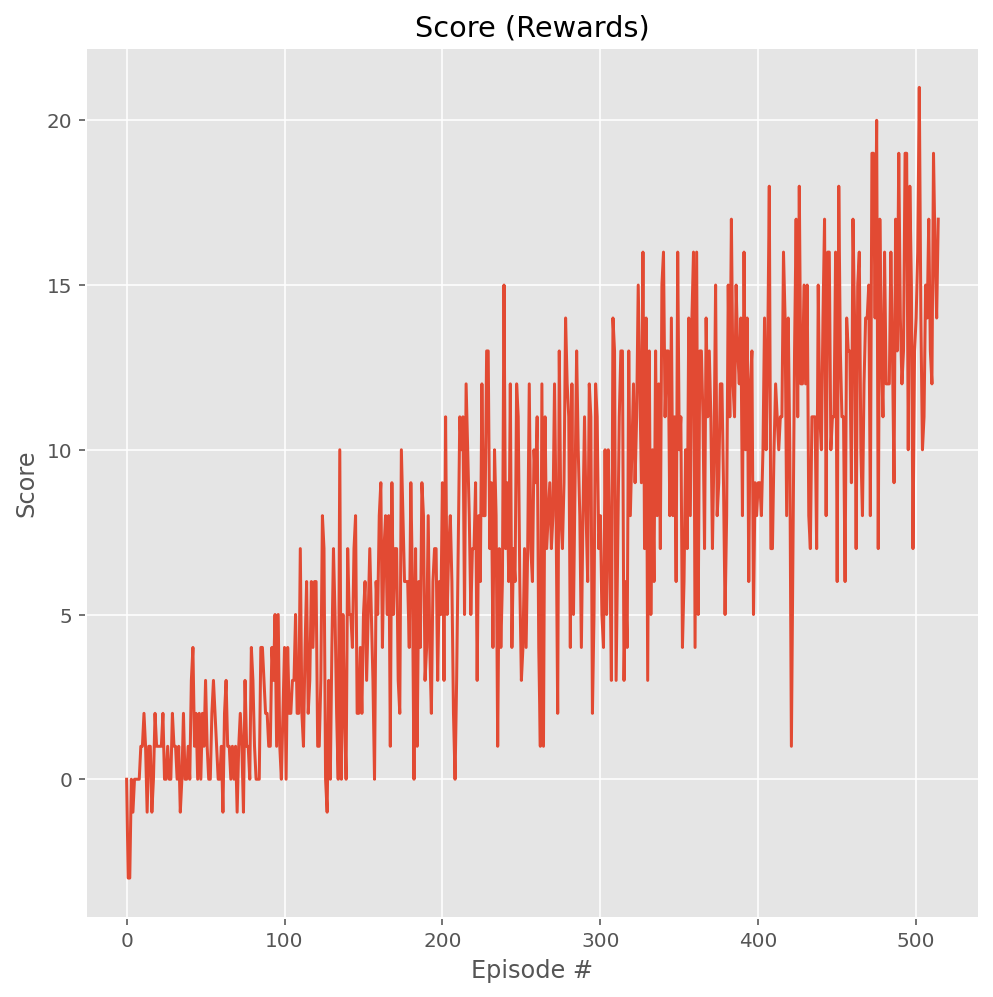

In [8]:
fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(111)
plt.plot(np.arange(len(scores)), scores)
plt.title('Score (Rewards)')
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.grid(True)      
plt.show()

In [9]:
agent.qnetwork_local.load_state_dict(torch.load('checkpoint.pth'))

In [11]:
env_info = env.reset(train_mode=False)[brain_name] # reset the environment
state = env_info.vector_observations[0]            # get the current state
score = 0                                          # initialize the score

while True:
    action = (int)(agent.act(state,0.01))          # select an action
    env_info = env.step(action)[brain_name]        # send the action to the environment
    next_state = env_info.vector_observations[0]   # get the next state
    reward = env_info.rewards[0]                   # get the reward
    done = env_info.local_done[0]                  # see if episode has finished
    score += reward                                # update the score
    state = next_state                             # roll over the state to next time step
    if done:                                       # exit loop if episode finished
        break
    
print("Score: {}".format(score))

Score: 18.0
